# Análisis de sentimientos de tweets para recomendar péliculas de IMDB

Mediante el dataset proporcionado por la web (https://www.kaggle.com/kazanova/sentiment140) y los recursos de TensorFlow lograremos clasificar nuevos tweets.
Cargamos primero el dataset y las librerias necesarias:

In [132]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tf.random.set_seed(44)

In [135]:
DATASIZE = 25000

data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)
d1 = pd.DataFrame(data.head(DATASIZE)) 
d2 = pd.DataFrame(data.tail(DATASIZE)) 
data = pd.concat([d1,d2])

In [136]:
data

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [138]:
data = data.rename(columns={0: 'target', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'content'})
data.head(1)

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."


In [139]:
#Busco datos que falten en el dataset
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
content,0,0.000000
username,0,0.000000
query,0,0.000000
date,0,0.000000
id,0,0.000000
target,0,0.000000


In [140]:
# El dataset esta divido al 50% con la misma cantidad de apariciones de comentarios negativos como positivos
data['target'] = data['target'].replace([0, 4],['Negative','Positive'])
data['target'].value_counts()

Negative    25000
Positive    25000
Name: target, dtype: int64

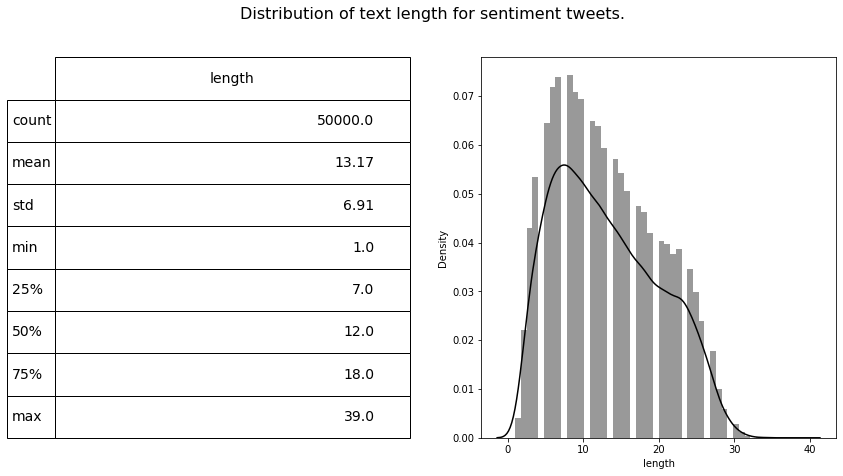

In [141]:
data['length'] = data.content.str.split().apply(len)

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data['length'], ax=ax1,color='black')
describe = data.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for sentiment tweets.', fontsize=16)

plt.show()

In [142]:
data.drop(['id','date','query','username','length'], axis=1, inplace=True)
data.target = data.target.replace({'Positive': 1, 'Negative': 0})
data.head()

,target,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [143]:
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()).lower()
        tokens = []
        for x in tweet.split():
            if x in english_words_set: 
                tokens.append(x)
            
        return " ".join(tokens)
            


In [144]:
# Limpio los datos evitando asi enlaces o caracteres no deseados (Estandarizado)

data.content = data.content.apply(lambda x: clean_tweet(x))
data.head()

,target,content
0,0,that s a you got of third day to do it d
1,0,is upset that he can t update his by it and mi...
2,0,i many for the ball to save the rest go out of
3,0,my whole body itchy and like on fire
4,0,no it s not at all i m mad why am i here becau...


In [145]:
dataset = tf.data.Dataset.from_tensor_slices((data['content'].values, data['target'].values))
# Mezclamos el data set
dataset = dataset.shuffle(len(data)).batch(1)

# En este caso tenemos una gran cantidad de tweets 1600000:
# Divido un 80% para entrenamiento y 20% para test. 
dataset_train = dataset.take(int(0.8 * len(data.values)))
dataset_test = dataset.skip(int(0.8 * len(data.values)))

print('Tamaño entrenamiento ', len(dataset_train))
print('Tamaño entrenamiento ', len(dataset_test))

for txt, value in dataset_train.take(5):
    print("Content", txt.numpy())
    print("Target", value.numpy())

Tamaño entrenamiento  40000
Tamaño entrenamiento  10000
Content [b'be back later maybe know juice still think day i hide he never find me never']
Target [1]
Content [b'go get em very cool let me know when you t busy the world and we can hang out']
Target [1]
Content [b's toast so to bed another week in the']
Target [0]
Content [b'still haven t got my coffee i m done help me']
Target [0]
Content [b'maybe that is what i meant what did i say']
Target [1]


In [146]:
# Vectorizado y tokenizacion de los datos 
# Tamaño maximo de un tweet en palabras : 50 (Obtenido de los resultados medios de graficos anteriores)
# Tarda bastante tiempo en desarrollar el vocabulario.

sequence_length = 50 

vectorize_layer = TextVectorization(
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = dataset_train.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [147]:
# Vectorizamos y mostramos uno de los comentarios del dataset de entrenamiento

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

text_batch, label_batch = next(iter(dataset_train))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Vectorized review",  vectorize_text(first_review, first_label))

Review tf.Tensor(b'that was a great idea i her to queen market with me on then it was good and it s', shape=(), dtype=string)
Vectorized review (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  17,   28,    5,   96,  345,    2,  103,    3, 1638, 1496,   26,
          18,   16,   84,    6,   28,   29,    7,    6,   14,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [148]:
print("254 ---> ",vectorize_layer.get_vocabulary()[254])
print("1613 ---> ",vectorize_layer.get_vocabulary()[1613])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

254 --->  movie
1613 --->  annual
Vocabulary size: 6447


In [149]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'i',
 'to',
 'the',
 'a',
 'it',
 'and',
 'my',
 'you',
 'is',
 'for',
 'in',
 'of',
 's',
 't',
 'on',
 'that',
 'me',
 'have',
 'so',
 'but',
 'm',
 'just',
 'be',
 'at',
 'with',
 'not',
 'was',
 'good',
 'this',
 'up',
 'day',
 'now',
 'can',
 'out',
 'get',
 'today',
 'all',
 'go',
 'no',
 'work',
 'are',
 'like',
 'do',
 'too',
 'your',
 'got',
 'back',
 'we',
 'what',
 'time',
 'love',
 'one',
 'am',
 'from',
 'will',
 'don',
 'about',
 'know',
 'some',
 'had',
 'u',
 'still',
 'new',
 'there',
 'how',
 'if',
 'well',
 'night',
 'see',
 'more',
 'they',
 'want',
 'last',
 'amp',
 'think',
 'when',
 'as',
 'off',
 'home',
 'here',
 'need',
 'oh',
 'then',
 'he',
 'an',
 'much',
 'has',
 'hope',
 'tomorrow',
 'again',
 'been',
 're',
 'sleep',
 'or',
 'great',
 'very',
 'only',
 'she',
 'why',
 'miss',
 'wish',
 'her',
 'feel',
 'school',
 'would',
 'sad',
 'bad',
 'right',
 'by',
 'way',
 'sorry',
 'happy',
 'did',
 'over',
 'them',
 'though',
 'fun',
 'nice',
 'b

In [150]:
# Vectorizamos el dataset de entrenamiento y test en base
# al modelo de vectorizacion creado anteriormente y mediante a la funcion que lo utiliza

train_ds = dataset_train.map(vectorize_text)
test_ds = dataset_test.map(vectorize_text)

In [151]:
# Guardado de datos en cache para facilitar el aprendizaje del modelo

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [152]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model1.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 64)          412608    
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 486,977
Trainable params: 486,977
Non-trainable params: 0
_________________________________________________________________


In [153]:
%%time

history1 = model1.fit(train_ds, epochs=10,
                    validation_data=test_ds)

%store history1

Epoch 1/10
 2458/40000 [>.............................] - ETA: 6:09 - loss: 0.6633 - binary_accuracy: 0.6073

KeyboardInterrupt: 

In [154]:
# Creación de la red neuronal
embedding_dim = 16

model2 = tf.keras.Sequential([
  layers.Embedding(len(vectorize_layer.get_vocabulary()) + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model2.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model2.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, None, 16)          103168    
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_6 ( (None, 16)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 17        
Total params: 103,185
Trainable params: 103,185
Non-trainable params: 0
_________________________________________________________________


In [155]:
%%time

history2 = model2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10)

%store history2

Epoch 1/10
13051/40000 [========>.....................] - ETA: 1:19 - loss: 0.6767 - binary_accuracy: 0.5813

KeyboardInterrupt: 

In [131]:
#embedding_layer = tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()), embedding_dim, input_length=50, weights=[embeddings_matrix], trainable=False)

model3 = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()) + 1, 100),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])


model3.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
model3.summary()

KeyboardInterrupt: 

In [ ]:
%%time

history3 = model.fit(train_ds,
                     epochs=10, 
                     validation_data=test_ds)

%store history3

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

# Analisis de sentimientos de personaje público

Utilizando la api de twitter obtenemos los tweets de barack obama y el modelo entrenado con anterioridad podemos comprobar con que precision es capaz de obtener los sentimientos de cada uno de los tweets.

In [ ]:
## Código de ejemplo (https://www.geeksforgeeks.org/python-api-user_timeline-in-tweepy/)


import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
from english_words import english_words_set

def twitterClient():

    # keys and tokens from the Twitter Dev Console
    consumer_key = 'QfHzmKICwbmttyZy7zdejcqKl'
    consumer_secret = 'aOrUpMfze7ijUSI8DQzHtkHodoVcUgLV2YMx2BSok4sKoKYHGA'
    access_token = '625111410-5oZNSPcdo0p1dfbuovFyUq6UCOKe28e2Luh8qSXf'
    access_token_secret = 'RgXvLhn52v3YAyXhvVHI6AlHqEeu2kuxaXy320Mw99TnP'

    # attempt authentication
    try:
        # create OAuthHandler object
        auth = OAuthHandler(consumer_key, consumer_secret)
        # set access token and secret
        auth.set_access_token(access_token, access_token_secret)
        # create tweepy API object to fetch tweets
        api = tweepy.API(auth)
    except:
        print("Error: Authentication Failed")
        
    return api

def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()).lower()
        tokens = []
        for x in tweet.split():
            if x in english_words_set: 
                tokens.append(x)
            
        return " ".join(tokens)
            

def get_tweet_sentiment(tweet):
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'
    
def get_tweets(api, query, count = 10):
    tweets = []

    try:
        # call twitter api to fetch tweets
        fetched_tweets = api.search(q = query, count = count, include_rts=True)
        for tweet in fetched_tweets:
            # empty dictionary to store required params of a tweet
            parsed_tweet = {}
            # saving text of tweet
            parsed_tweet['text'] = tweet.text
            # saving sentiment of tweet
            parsed_tweet['sentiment'] = get_tweet_sentiment(tweet.text)

            # appending parsed tweet to tweets list
            if tweet.retweet_count > 0:
                # if tweet has retweets, ensure that it is appended only once
                if parsed_tweet not in tweets:
                    tweets.append(parsed_tweet)
            else:
                tweets.append(parsed_tweet)
            # return parsed tweets
            return tweets
    except tweepy.TweepError as e:
        # print error (if any)
        print("Error : " + str(e))

def main():
    # creating object of TwitterClient Class
    api = twitterClient()
    # calling function to get tweets
    tweets = get_tweets(api, query = 'Donald Trump', count = 200)
    
    print(tweets)
    # picking positive tweets from tweets
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    # percentage of positive tweets
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))
    # picking negative tweets from tweets
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    # percentage of negative tweets
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))
    # percentage of neutral tweets
    print("Neutral tweets percentage: {} % \
        ".format(100*(len(tweets) -(len( ntweets )+len( ptweets)))/len(tweets)))

    # printing first 5 positive tweets
    print("\n\nPositive tweets:")
    for tweet in ptweets[:10]:
        print(tweet['text'])

    # printing first 5 negative tweets
    print("\n\nNegative tweets:")
    for tweet in ntweets[:10]:
                print(tweet['text'])

In [ ]:
main()

### Como podemos observar en este primer ejemplo clasificar el sentimiento de un tweet es una tarea bastante compleja y este caso lo hace de manera incorrecta ya que no es capaz de captar la negatividad del primer tweet.

In [ ]:
### api = twitterClient()
timeline = api.user_timeline(screen_name='@BarackObama',count=20,tweet_mode="extended", include_rts=True, exclude_replies=False)
# Iterate and print tweets
textonly_tweets = [tweet.full_text for tweet in timeline]
print(*textonly_tweets, sep = "\n")

# Recomendador de películas mediante los sentimientos expresados en twitter